# GAN





## 1-1 GAN이란?

### 1-1 Vanilla GAN

In [1]:
import torch
print(torch.__version__)

2.0.1+cu118


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
from tqdm.auto import tqdm # 진행상태 확인하는 함수

import matplotlib.pyplot as plt

In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00


In [4]:
#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, ), (0.5, )) # -1, 1
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:00<00:00, 115739153.61it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5164144.94it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 61538900.87it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26789425.55it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



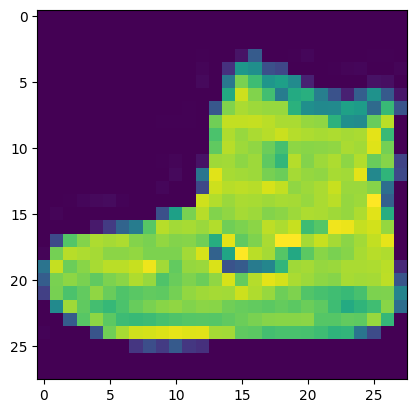

In [6]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0))

In [7]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

학습이 된 Gan모델에 노이즈값을 넣은 뒤 예측한 이미지를 보여주는 함수입니다.

In [8]:
def plot_generated_images(generator):
    # 100개의 노이즈 값을 생성합니다.
    noise = torch.rand((100, 100), device=device)
    with torch.no_grad():
        make_images = generator(noise).detach().cpu() # 노이즈값을 통해서 GAN으로 이미지 생성합니다.
    make_images = make_images.reshape(100, 1, 28,28) # Mnist 사이즈와 동일하게 바꿔줍니다.
    plt.figure(figsize=(10,10)) # 이미지 크기 지정
    for i in range(make_images.shape[0]): #이미지 갯수 100만큼 반복
        plt.subplot(10, 10, i+1) #바둑판식으로 표현
        plt.imshow(make_images[i].permute(1, 2, 0),plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout()

Vanilla GAN 모델링에 관한 코드입니다.
GAN은 2개의 모델이 필수적으로 사용을 하게 됩니다.

실제이미지와 가짜 이미지를 판별해주는 Discriminator
가짜이미지를 생성하는 Generator 모델입니다.
모델마다 각자의 optimizer를 갖고 있으며 --> 충돌을 방지를 합니다.

데이터는 Fashion Mnist데이터를 이용하여 실습하겠습니다.

In [9]:
epochs = 20  # 반복 횟수를 정해줍니다.
batch_size = 64 # 배치사이즈를 정해줍니다.

Generator 모델을 만듭니다.
입력데이터는 100개의 노이즈 이며 3층으로 쌓은 FFN 입니다.
활성함수는 ReLU를 사용하였고, 마지막에는 Tanh를 사용하였습니다.

Binary_crossetropy를 사용하여 이진 분류를 사용하였고, optimizer는 아까 규제를 넣은 adam을 사용하였습니다.

Dropout을 사용하게 되었습니다.

Generator의 최종 결과는 784이고 이는 mnist의 이미지 크기와 동일합니다.


In [10]:
# 생성자
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(512, 784),
            nn.Tanh(),  # sigmoid의 일종 -1 ~ 1
        )

    def forward(self, x):
        x_prime = self.generator(x)
        return x_prime

discriminator 모델을 만듭니다.
입력데이터는 minist파일의 크기이며 3층으로 쌓은 FFN 모델입니다.
Generator와 다르게 unit의 수가 점점 줄어드는 것을 확인 할 수 있습니다.

마지막 활성함수는 sigmoid를 사용함으로서 0 1사이에 거짓 이미지인지 실제 이미지인지를 판별을 해주는 것입니다.

In [11]:
# 판별자
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

        # for param in self.discriminator.parameters():
        #     param.requires_grad = False

    def forward(self, x):
        output = self.discriminator(x)
        return output


이제는 두 모델을 합칩니다.  
실제이미지와 가짜이미지를 판결하기 위해서 Binary_CrossEntropy를 사용하였고,  
input의 데이터는 가짜이미지이고, output은 실제인지 가짜인지 판별해주는 discriminator의 결과값입니다.

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_g = Generator()
model_g.to(device)
model_d = Discriminator()
model_d.to(device)

criterion = nn.BCELoss()

#옵티마이저, 손실함수 지정
optimizer_g = optim.Adam(model_g.parameters(), lr=1e-4)
optimizer_d = optim.Adam(model_d.parameters(), lr=1e-4)

scheduler_g = StepLR(optimizer_g, step_size=5, gamma=0.7)
scheduler_d = StepLR(optimizer_d, step_size=5, gamma=0.7)

모델을 학습시키는 코드입니다.

위에서 설정한 Epochs 수만큼 학습을 하게 되고, batch_count만큼 반복하게 됩니다.  

진짜 이미지와 가짜 이미지를 합친 후  
그 크기만큼의 배열을 생성한 뒤 실제 이미지에는 0.9의 값을 주고 가짜 이미지에는 0의 값을 줍니다.  
그 후 discriminator를 학습을 시킵니다.  
배치사이즈 크기만큼 배열을 생성한 뒤 값을 1로 세팅하여 gan에 노이즈값과 함께 학습을 시킵니다.

In [14]:
# generator가 생성한 이미지를 저장해놓을 리스트입니다.
img_list = []

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 0.9 # label smoothing = 0.9
fake_label = 0.1

fixed_noise = torch.rand((20, 100), device=device)

total_step = len(train_loader)
for epoch in range(1, epochs + 1):
    for i, (data, _) in enumerate(tqdm(iter(train_loader))):
        # Real 데이터로 discriminator를 학습
        data = data.view(-1, 28*28).to(device)
        # print(data.shape)
        now_batch_size = data.size()[0]

        # 실제 이미지이므로 Discriminator는 1로 판단해야 합니다.
        real_labels = torch.full((now_batch_size, 1), real_label,
                           dtype=torch.float, device=device)
        fake_labels = torch.full((now_batch_size, 1), fake_label,
                           dtype=torch.float, device=device)

        output = model_d(data)  # 원본 데이터
        real_score = output
        d_loss_real = criterion(output, real_labels)    # 원본은 1로 예측해야 한다.

        # Fake 데이터로 discriminator 학습
        noise = torch.randn(now_batch_size, 100).to(device) # 노이즈 데이터를 생성합니다.
        # Generator를 이용해 가짜 이미지를 생성합니다
        # 여기서 generator가 생성한 이미지는 generator에는 영향을 미치지 않기 위해 detach() 합니다.
        fake_data = model_g(noise).detach()
        # print(fake_data.shape)

        # D를 이용해 데이터의 진위를 판별합니다
        output = model_d(fake_data)
        fake_score = output
        # D의 손실값을 계산합니다
        d_loss_fake = criterion(output, fake_labels)    # Fake라고 예측해야 cost가 낮아지도록 학

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_discriminator = d_loss_real + d_loss_fake
        loss_discriminator.backward()
        optimizer_d.step()

        # Generator를 학습시킵니다.

        noise = torch.randn(now_batch_size, 100).to(device) # 노이즈 데이터를 생성합니다.
        fake_data = model_g(noise)
        output = model_d(fake_data)

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_generator = criterion(output, real_labels) # Fake 데이터인데 real로 예측하면 cost 커짐
        loss_generator.backward()
        # G를 업데이트 합니다
        optimizer_g.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, epochs, i+1, total_step, loss_discriminator.item(), loss_generator.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    scheduler_g.step()
    scheduler_d.step()

    with torch.no_grad():
        fake = model_g(fixed_noise).detach().cpu()

    make_images = fake.reshape(20, 1, 28, 28) # Mnist 사이즈와 동일하게 바꿔줍니다.
    img_list.append(make_images)


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/20], Step [200/938], d_loss: 0.7662, g_loss: 2.0122, D(x): 0.81, D(G(z)): 0.22
Epoch [1/20], Step [400/938], d_loss: 0.8399, g_loss: 2.2362, D(x): 0.71, D(G(z)): 0.18
Epoch [1/20], Step [600/938], d_loss: 0.7342, g_loss: 2.5365, D(x): 0.79, D(G(z)): 0.14
Epoch [1/20], Step [800/938], d_loss: 0.7172, g_loss: 2.4855, D(x): 0.83, D(G(z)): 0.15


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/20], Step [200/938], d_loss: 0.8991, g_loss: 1.2339, D(x): 0.81, D(G(z)): 0.34
Epoch [2/20], Step [400/938], d_loss: 0.9137, g_loss: 1.3132, D(x): 0.84, D(G(z)): 0.35
Epoch [2/20], Step [600/938], d_loss: 0.7662, g_loss: 1.9477, D(x): 0.83, D(G(z)): 0.17
Epoch [2/20], Step [800/938], d_loss: 0.7685, g_loss: 1.9034, D(x): 0.84, D(G(z)): 0.18


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/20], Step [200/938], d_loss: 0.7609, g_loss: 1.8633, D(x): 0.87, D(G(z)): 0.17
Epoch [3/20], Step [400/938], d_loss: 0.7515, g_loss: 1.9119, D(x): 0.80, D(G(z)): 0.15
Epoch [3/20], Step [600/938], d_loss: 0.7447, g_loss: 1.9545, D(x): 0.83, D(G(z)): 0.14
Epoch [3/20], Step [800/938], d_loss: 0.7294, g_loss: 2.0844, D(x): 0.82, D(G(z)): 0.13


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/20], Step [200/938], d_loss: 0.7304, g_loss: 2.2238, D(x): 0.87, D(G(z)): 0.13
Epoch [4/20], Step [400/938], d_loss: 0.6976, g_loss: 1.8217, D(x): 0.88, D(G(z)): 0.15
Epoch [4/20], Step [600/938], d_loss: 0.7520, g_loss: 1.9666, D(x): 0.84, D(G(z)): 0.17
Epoch [4/20], Step [800/938], d_loss: 0.7393, g_loss: 2.0378, D(x): 0.85, D(G(z)): 0.18


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/20], Step [200/938], d_loss: 0.7771, g_loss: 1.8581, D(x): 0.83, D(G(z)): 0.20
Epoch [5/20], Step [400/938], d_loss: 0.8884, g_loss: 1.7932, D(x): 0.81, D(G(z)): 0.25
Epoch [5/20], Step [600/938], d_loss: 0.7345, g_loss: 2.2093, D(x): 0.83, D(G(z)): 0.13
Epoch [5/20], Step [800/938], d_loss: 0.7454, g_loss: 1.8982, D(x): 0.85, D(G(z)): 0.19


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/20], Step [200/938], d_loss: 0.7957, g_loss: 1.7677, D(x): 0.85, D(G(z)): 0.22
Epoch [6/20], Step [400/938], d_loss: 0.8166, g_loss: 1.6823, D(x): 0.76, D(G(z)): 0.18
Epoch [6/20], Step [600/938], d_loss: 0.7769, g_loss: 2.0547, D(x): 0.82, D(G(z)): 0.17
Epoch [6/20], Step [800/938], d_loss: 0.7999, g_loss: 2.0217, D(x): 0.87, D(G(z)): 0.20


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/20], Step [200/938], d_loss: 0.7793, g_loss: 1.8534, D(x): 0.81, D(G(z)): 0.19
Epoch [7/20], Step [400/938], d_loss: 0.7984, g_loss: 1.6425, D(x): 0.84, D(G(z)): 0.23
Epoch [7/20], Step [600/938], d_loss: 0.8352, g_loss: 1.7781, D(x): 0.83, D(G(z)): 0.23
Epoch [7/20], Step [800/938], d_loss: 0.7684, g_loss: 1.8188, D(x): 0.81, D(G(z)): 0.16


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/20], Step [200/938], d_loss: 0.7298, g_loss: 1.9548, D(x): 0.88, D(G(z)): 0.16
Epoch [8/20], Step [400/938], d_loss: 0.7898, g_loss: 1.8476, D(x): 0.83, D(G(z)): 0.15
Epoch [8/20], Step [600/938], d_loss: 0.7721, g_loss: 1.7284, D(x): 0.81, D(G(z)): 0.14
Epoch [8/20], Step [800/938], d_loss: 0.7284, g_loss: 1.8573, D(x): 0.86, D(G(z)): 0.18


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/20], Step [200/938], d_loss: 0.7642, g_loss: 1.8521, D(x): 0.85, D(G(z)): 0.19
Epoch [9/20], Step [400/938], d_loss: 0.7849, g_loss: 1.7153, D(x): 0.83, D(G(z)): 0.19
Epoch [9/20], Step [600/938], d_loss: 0.7754, g_loss: 1.9235, D(x): 0.82, D(G(z)): 0.18
Epoch [9/20], Step [800/938], d_loss: 0.8080, g_loss: 1.4655, D(x): 0.83, D(G(z)): 0.21


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/20], Step [200/938], d_loss: 0.7849, g_loss: 1.6432, D(x): 0.86, D(G(z)): 0.22
Epoch [10/20], Step [400/938], d_loss: 0.8078, g_loss: 1.7252, D(x): 0.80, D(G(z)): 0.18
Epoch [10/20], Step [600/938], d_loss: 0.7904, g_loss: 1.7319, D(x): 0.83, D(G(z)): 0.19
Epoch [10/20], Step [800/938], d_loss: 0.7386, g_loss: 2.1915, D(x): 0.82, D(G(z)): 0.13


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [11/20], Step [200/938], d_loss: 0.7841, g_loss: 1.7641, D(x): 0.83, D(G(z)): 0.22
Epoch [11/20], Step [400/938], d_loss: 0.7687, g_loss: 1.7146, D(x): 0.85, D(G(z)): 0.18
Epoch [11/20], Step [600/938], d_loss: 0.7887, g_loss: 1.9991, D(x): 0.83, D(G(z)): 0.19
Epoch [11/20], Step [800/938], d_loss: 0.9384, g_loss: 1.4324, D(x): 0.84, D(G(z)): 0.34


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [12/20], Step [200/938], d_loss: 0.8182, g_loss: 1.5553, D(x): 0.82, D(G(z)): 0.21
Epoch [12/20], Step [400/938], d_loss: 0.8142, g_loss: 1.6130, D(x): 0.81, D(G(z)): 0.21
Epoch [12/20], Step [600/938], d_loss: 0.8054, g_loss: 1.6196, D(x): 0.82, D(G(z)): 0.22
Epoch [12/20], Step [800/938], d_loss: 0.7915, g_loss: 1.7629, D(x): 0.81, D(G(z)): 0.19


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [13/20], Step [200/938], d_loss: 0.8317, g_loss: 1.5268, D(x): 0.81, D(G(z)): 0.22
Epoch [13/20], Step [400/938], d_loss: 0.8207, g_loss: 1.6313, D(x): 0.83, D(G(z)): 0.21
Epoch [13/20], Step [600/938], d_loss: 0.7944, g_loss: 1.5693, D(x): 0.80, D(G(z)): 0.20
Epoch [13/20], Step [800/938], d_loss: 0.8830, g_loss: 1.7472, D(x): 0.76, D(G(z)): 0.21


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [14/20], Step [200/938], d_loss: 0.8435, g_loss: 1.5655, D(x): 0.79, D(G(z)): 0.21
Epoch [14/20], Step [400/938], d_loss: 0.8998, g_loss: 1.4346, D(x): 0.83, D(G(z)): 0.25
Epoch [14/20], Step [600/938], d_loss: 0.8236, g_loss: 1.8482, D(x): 0.83, D(G(z)): 0.22
Epoch [14/20], Step [800/938], d_loss: 0.8960, g_loss: 1.5224, D(x): 0.82, D(G(z)): 0.26


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [15/20], Step [200/938], d_loss: 0.8338, g_loss: 1.4075, D(x): 0.84, D(G(z)): 0.24
Epoch [15/20], Step [400/938], d_loss: 0.8455, g_loss: 1.7907, D(x): 0.79, D(G(z)): 0.23
Epoch [15/20], Step [600/938], d_loss: 0.8609, g_loss: 1.7314, D(x): 0.79, D(G(z)): 0.19
Epoch [15/20], Step [800/938], d_loss: 0.8418, g_loss: 1.7259, D(x): 0.77, D(G(z)): 0.18


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [16/20], Step [200/938], d_loss: 0.8107, g_loss: 1.8195, D(x): 0.82, D(G(z)): 0.17
Epoch [16/20], Step [400/938], d_loss: 0.7977, g_loss: 1.7838, D(x): 0.79, D(G(z)): 0.18
Epoch [16/20], Step [600/938], d_loss: 0.8295, g_loss: 1.7072, D(x): 0.79, D(G(z)): 0.17
Epoch [16/20], Step [800/938], d_loss: 0.9005, g_loss: 1.5711, D(x): 0.77, D(G(z)): 0.22


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [17/20], Step [200/938], d_loss: 0.8957, g_loss: 1.4741, D(x): 0.78, D(G(z)): 0.23
Epoch [17/20], Step [400/938], d_loss: 0.8125, g_loss: 1.8039, D(x): 0.83, D(G(z)): 0.21
Epoch [17/20], Step [600/938], d_loss: 0.8679, g_loss: 1.7925, D(x): 0.74, D(G(z)): 0.17
Epoch [17/20], Step [800/938], d_loss: 0.8009, g_loss: 1.6579, D(x): 0.84, D(G(z)): 0.21


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [18/20], Step [200/938], d_loss: 0.8890, g_loss: 1.6828, D(x): 0.78, D(G(z)): 0.20
Epoch [18/20], Step [400/938], d_loss: 0.8439, g_loss: 1.5326, D(x): 0.80, D(G(z)): 0.20
Epoch [18/20], Step [600/938], d_loss: 0.8705, g_loss: 1.6133, D(x): 0.78, D(G(z)): 0.23
Epoch [18/20], Step [800/938], d_loss: 0.8381, g_loss: 1.6595, D(x): 0.80, D(G(z)): 0.23


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [19/20], Step [200/938], d_loss: 0.8813, g_loss: 1.8667, D(x): 0.82, D(G(z)): 0.22
Epoch [19/20], Step [400/938], d_loss: 0.8747, g_loss: 1.6179, D(x): 0.76, D(G(z)): 0.21
Epoch [19/20], Step [600/938], d_loss: 0.9223, g_loss: 1.5559, D(x): 0.77, D(G(z)): 0.25
Epoch [19/20], Step [800/938], d_loss: 0.8490, g_loss: 1.5807, D(x): 0.79, D(G(z)): 0.22


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [20/20], Step [200/938], d_loss: 0.8724, g_loss: 1.6772, D(x): 0.76, D(G(z)): 0.22
Epoch [20/20], Step [400/938], d_loss: 0.8425, g_loss: 1.4563, D(x): 0.82, D(G(z)): 0.26
Epoch [20/20], Step [600/938], d_loss: 0.9089, g_loss: 1.3896, D(x): 0.85, D(G(z)): 0.33
Epoch [20/20], Step [800/938], d_loss: 0.9352, g_loss: 1.3791, D(x): 0.74, D(G(z)): 0.27


In [15]:
model_g

Generator(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [16]:
img_list[0]

tensor([[[[ 1.4122e-01, -1.0795e-01,  5.1611e-02,  ...,  8.7681e-02,
           -3.4851e-02,  3.3592e-02],
          [-2.5231e-05, -1.1295e-01, -4.0142e-02,  ..., -2.8127e-01,
           -9.6926e-02,  1.4483e-01],
          [-2.3924e-01, -1.4967e-01, -3.5477e-02,  ...,  1.1604e-01,
           -1.0205e-01, -8.3842e-02],
          ...,
          [ 2.1218e-01,  3.0830e-02,  6.2212e-02,  ...,  2.2887e-01,
            1.7797e-01, -7.4939e-02],
          [-1.5083e-01,  7.6127e-03, -1.4249e-01,  ..., -2.3511e-02,
            1.5950e-01,  2.3730e-01],
          [ 1.1204e-01,  1.2140e-01,  1.2744e-01,  ...,  1.1022e-01,
           -1.8364e-02,  5.0872e-02]]],


        [[[ 1.3328e-01, -1.0106e-01,  1.9374e-02,  ...,  7.4334e-02,
           -2.7092e-02,  2.7829e-02],
          [-3.8381e-03, -9.1307e-02, -3.3231e-02,  ..., -2.4627e-01,
           -8.7884e-02,  1.0146e-01],
          [-2.0602e-01, -1.3189e-01, -2.1850e-02,  ...,  9.3624e-02,
           -9.0417e-02, -6.6205e-02],
          ...,
   

In [17]:
make_images.shape[0]

20

In [18]:
i

937

In [19]:
make_images.shape

torch.Size([20, 1, 28, 28])

In [20]:
len(img_list)

20

In [21]:
for make_images in img_list:
    if make_images.shape[1] != 784:
        plt.figure(figsize=(4,4)) # 이미지 크기 지정
        for i in range(make_images.shape[0]): #이미지 갯수만큼 반복
            plt.subplot(4, 5, i+1) #바둑판식으로 표현
            plt.imshow(make_images[i].permute(1, 2, 0))
            plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

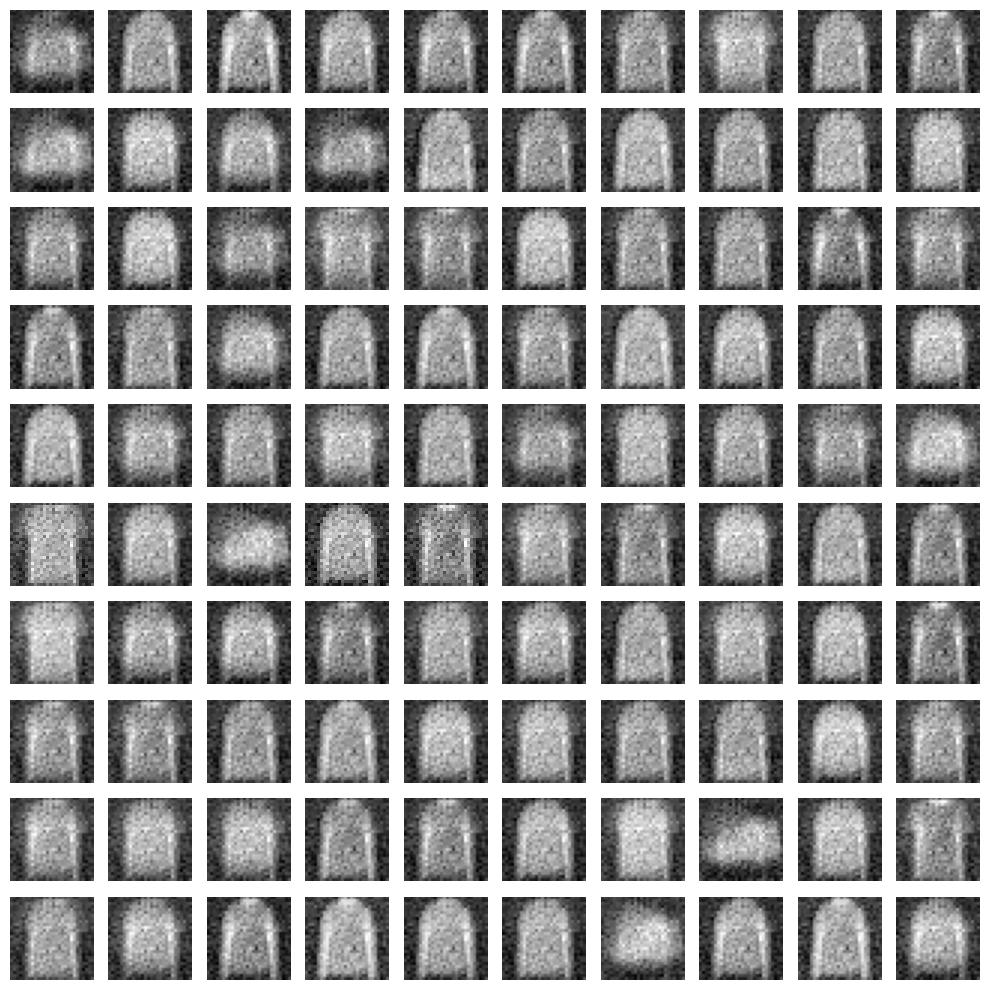

In [22]:
plot_generated_images(model_g)

### 1-2 DCGAN

이번에는 GAN의 응용모델인 DCGAN을 설명하겠습니다.  
DCGAN은 "Deep Convolutional Generative Adversarial Nets"의 약자이며 FFN 부분을 CNN으로 바꾼 부분입니다.  
DCGAN이 탄생하게 된 것은 기존에 있던 GAN이 불안정하며 새로 만들어진 결과물들이 좋은지를 판단하기가 어렵게 되어 나오게 된 것입니다.  
기존에 있던 CNN과 다른 점은 Pooling layer를 사용하지 않고 이를 strides로 교체를 한 것입니다.

Vanilla GAN을 했을 당시에는 -1 ~ 1 사이의 값으로 하였으나
DCGAN에서는 결과가 좋지 않아 0 ~ 1 사이의 값으로 정규화를 진행하였습니다.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [24]:
import os

os.path.abspath('.')

'/content'

In [26]:
import zipfile

house_zip = zipfile.ZipFile('/content/drive/MyDrive/ML/data/img_align_celeba.zip')
house_zip.extractall('./data/celeba')
house_zip.close()

In [27]:
dataroot = "./data/celeba/img_align_celeba/"

In [28]:
image_list = []

for fn in os.listdir(dataroot):
    image_list.append(dataroot+fn)

In [29]:
set([img.split('.')[-1] for img in image_list])

{'jpg'}

In [30]:
image_list[0]

'./data/celeba/img_align_celeba/090090.jpg'

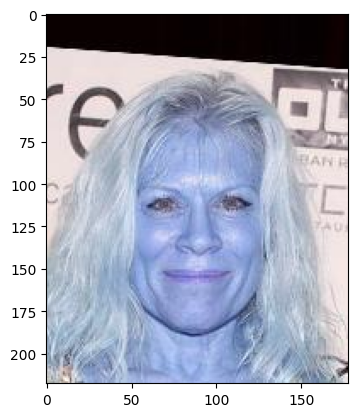

In [31]:
import cv2
img = cv2.imread(image_list[0])

import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [33]:
face_dataset = datasets.ImageFolder(root='./data/celeba',
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [34]:
transform = transforms.Compose([
                            transforms.Resize(64),
                            transforms.CenterCrop(64),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [35]:
from torch.utils.data import Dataset

In [36]:
class CustomerDataset(Dataset):
    def __init__(self, img_path_list, transform=None):
        self.img_path_list = img_path_list
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)

        if self.transform is not None:
            image = self.transform(image=image)['image']

        label = '_'.join(img_path.split('_')[2:])[:-5]
        return image, label

    def __len__(self):
        return len(self.img_path_list)

In [39]:
from PIL import Image

In [40]:
class FaceDataset(Dataset):
    def __init__(self, image_file_list:list, labels=None, transform=None):
        self.image_list = image_file_list   # 데이터 저장하는 부분
        self.transform = transform
        self.labels = labels

    def __getitem__(self, index):
        # [1, 2, 3][1] -> 2
        # index로 특정 이미지 경로 가져옴
        image_file_path = self.image_list[index]
        # print(image_file_path)

        # 해당 경로로 이미지 불러옴
        image = Image.open(image_file_path)
        # image = cv2.imread(image_file_path)

        # transform 있으면, transform 적용
        if self.transform:
            # print('트랜스폼 적용')
            image = self.transform(image)

        # 그렇게 처리된 이미지 변환
        return image

    def __len__(self):
        # 개수 세기
        # print('개수 반환')
        return len(self.image_list)

face_dataset = FaceDataset(image_list, transform=transform)

In [41]:
image_list

['./data/celeba/img_align_celeba/090090.jpg',
 './data/celeba/img_align_celeba/048518.jpg',
 './data/celeba/img_align_celeba/106964.jpg',
 './data/celeba/img_align_celeba/054744.jpg',
 './data/celeba/img_align_celeba/178083.jpg',
 './data/celeba/img_align_celeba/161707.jpg',
 './data/celeba/img_align_celeba/113726.jpg',
 './data/celeba/img_align_celeba/104775.jpg',
 './data/celeba/img_align_celeba/079497.jpg',
 './data/celeba/img_align_celeba/149560.jpg',
 './data/celeba/img_align_celeba/191338.jpg',
 './data/celeba/img_align_celeba/163730.jpg',
 './data/celeba/img_align_celeba/199200.jpg',
 './data/celeba/img_align_celeba/019788.jpg',
 './data/celeba/img_align_celeba/171175.jpg',
 './data/celeba/img_align_celeba/022427.jpg',
 './data/celeba/img_align_celeba/046202.jpg',
 './data/celeba/img_align_celeba/135554.jpg',
 './data/celeba/img_align_celeba/117430.jpg',
 './data/celeba/img_align_celeba/085617.jpg',
 './data/celeba/img_align_celeba/003360.jpg',
 './data/celeba/img_align_celeba/0

In [42]:
face_dataset[0].shape

torch.Size([3, 64, 64])

In [43]:
len(face_dataset)

202599

In [44]:
batch_size=128
dataloader = torch.utils.data.DataLoader(face_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Generator를 선언하는 부분입니다.  
해당 코드에서 중요한 것은 Strides 부분입니다.  
처음 보는 함수들이 있습니다.

LeakyReLU는 활성함수 중 하나입니다.  
Relu는 0이하인 값들은 전부 0으로 바꿔주지만 LeakyReLU는 0으로 수렴하게 해줍니다.  
Conv2DTranspose라는 Deconvolution라고 불리우고 이미지 해상도를 올리 때 사용합니다.  
Conv2D와 사용법은 동일하고 Conv2D를 거꾸로 해놓은 버전이라고 생각하시면 됩니다.

처음 FFN으로 통하여 이미지의 크기를 지정해줍니다.  
그 후 리사이즈를 통해 이미지가 Conv2D에 학습 할 수 있도록 바꿔줍니다.

Conv2DTranspose에서 필터사이즈 256, 커널사이즈 4, strides 2, padding은 same으로 설정 하였습니다.  
다층 Conv2D를 지나고 Dense로 가게 되면 28  28  1 이미지의 형태가 됩니다.

Summary 부분에서 자세하게 설명하겠습니다.

In [45]:
# 생성자
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(64, 64*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(),

            nn.ConvTranspose2d(64*8, 64*4, kernel_size=4, stride=2, padding=1), # 같은 크기로 Conv2D
            nn.BatchNorm2d(64*4),
            nn.ReLU(),

            nn.ConvTranspose2d(64*4, 64*2, kernel_size=4, stride=2, padding=1), # Deconvolution
            nn.BatchNorm2d(64*2),
            nn.ReLU(),

            nn.ConvTranspose2d(64*2, 64*1, kernel_size=4, stride=2, padding=1), # 같은 크기로 Conv2D
            nn.BatchNorm2d(64*1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), # 같은 크기로 Conv2D
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.generator(x)
        return x


In [46]:
import torchsummary
torchsummary.summary(Generator().cuda(), (64, 1, 1, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         524,288
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,408
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,416
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,136
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,075
             Tanh-14            [-1, 3,

Summary를 살펴 보게 되면  
첫 Conv2D를 지나게 되면 14 * 14 * 256의 이미지 형태가 됩니다.  
Conv2DTranspose 부분에서 지나게 되면서 28 * 28 * 256 형태로 바뀌게 됩니다.  
이는 strides부분이 기존에 있던 크기를 확장시키게 됩니다.  
strides가 3이면 이미지는 42 * 42 * 256 형태가 되는 것입니다.  
padding을 설정하게 됨으로써 strides 부분만 영향을 주게 되는 것입니다.

위에 코드에서 strides와 padding을 조정하고 summary를 출력을 해보면 이해하기 쉬울 것입니다.

Discriminator는 FFN 부분이 Conv2D로 바뀐 말고는 달라진 점은 없습니다.

Conv2D 코드를 보면 strides 부분이 추가가 되어있으며 Polling 부분이 없는 것이 확인 됩니다.

Adam이 아닌 RMSprop으로 진행하였습니다.

In [47]:
# 생성자
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.4),
            nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.4),
            nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            # nn.Dropout(p=0.4),
            nn.Linear(64*8*4*4, 1),
            nn.Sigmoid(),

        )

    def forward(self, x):
        x = self.discriminator(x)
        return x


Summary를 살펴보면 Padding이 설정되지 않기 대문에 커널 사이즈의 영향을 받아 이미지 크기가 줄어 들었습니다.  
또한 strides 부분이 2로 설정 되어있있기에 이미지의 2번 째 Conv2D 부터는 이미지 크기가 줄어드는 게 보입니다.

In [48]:
torchsummary.summary(Discriminator().cuda(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
           Dropout-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,200
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
           Dropout-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 256, 8, 8]         524,544
       BatchNorm2d-9            [-1, 256, 8, 8]             512
        LeakyReLU-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-12            [-1, 512, 4, 4]           1,024
        LeakyReLU-13            [-1, 512, 4, 4]               0
          Flatten-14                 [-

학습을 시키는 부분은 GAN 기본 모델과 다르지 않습니다.

In [49]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_g = Generator()
model_g.to(device)
model_d = Discriminator()
model_d.to(device)

# for para in model_d.parameters():
#     para.requires_grad = False

criterion = nn.BCELoss().cuda()
optimizer_g = optim.Adam(model_g.parameters(), lr=2e-3)
optimizer_d = optim.Adam(model_d.parameters(), lr=2e-3)
scheduler_g = StepLR(optimizer_g, step_size=5, gamma=0.7)
scheduler_d = StepLR(optimizer_d, step_size=5, gamma=0.7)

In [51]:
# generator가 생성한 이미지를 저장해놓을 리스트입니다.
img_list = []

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 0.9 # label smoothing = 0.9
fake_label = 0.

fixed_noise = torch.rand((20, 64, 1, 1), device=device)

epochs = 5
total_step = len(dataloader)

for epoch in range(1, epochs + 1):
    for i, data in enumerate(tqdm(iter(dataloader))):
        # Real 데이터로 discriminator를 학습
        data = data.to(device)
        # print(data.shape)
        now_batch_size = data.size()[0]

        # 실제 이미지이므로 Discriminator는 1로 판단해야 합니다.
        real_labels = torch.full((now_batch_size, 1), real_label,
                           dtype=torch.float, device=device)
        fake_labels = torch.full((now_batch_size, 1), fake_label,
                           dtype=torch.float, device=device)

        output = model_d(data)
        real_score = output
        d_loss_real = criterion(output, real_labels)

        # Fake 데이터로 discriminator 학습
        noise = torch.randn(now_batch_size, 64, 1, 1).to(device) # 노이즈 데이터를 생성합니다.
        # Generator를 이용해 가짜 이미지를 생성합니다
        fake_data = model_g(noise).detach()
        # print(fake_data.shape)

        # D를 이용해 데이터의 진위를 판별합니다
        output = model_d(fake_data)
        fake_score = output
        # D의 손실값을 계산합니다
        d_loss_fake = criterion(output, fake_labels)

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_discriminator = d_loss_real + d_loss_fake
        loss_discriminator.backward()
        optimizer_d.step()

        # Generator를 학습시킵니다.

        noise = torch.randn(now_batch_size, 64, 1, 1).to(device) # 노이즈 데이터를 생성합니다.
        fake_data = model_g(noise)
        output = model_d(fake_data)

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_generator = criterion(output, real_labels)
        loss_generator.backward()
        # G를 업데이트 합니다
        optimizer_g.step()

        if (i+1) % 50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, epochs, i+1, total_step, loss_discriminator.item(), loss_generator.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    scheduler_g.step()
    scheduler_d.step()

    with torch.no_grad():
        fake = model_g(fixed_noise).detach().cpu()

    img_list.append(fake)


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [1/5], Step [50/1583], d_loss: 0.4628, g_loss: 6.2507, D(x): 0.85, D(G(z)): 0.05
Epoch [1/5], Step [100/1583], d_loss: 0.4192, g_loss: 7.3576, D(x): 0.91, D(G(z)): 0.03
Epoch [1/5], Step [150/1583], d_loss: 0.3994, g_loss: 7.6401, D(x): 0.86, D(G(z)): 0.03
Epoch [1/5], Step [200/1583], d_loss: 0.3733, g_loss: 5.2795, D(x): 0.87, D(G(z)): 0.02
Epoch [1/5], Step [250/1583], d_loss: 0.3759, g_loss: 5.8692, D(x): 0.92, D(G(z)): 0.03
Epoch [1/5], Step [300/1583], d_loss: 0.4014, g_loss: 4.8351, D(x): 0.90, D(G(z)): 0.02
Epoch [1/5], Step [350/1583], d_loss: 0.3717, g_loss: 5.5465, D(x): 0.85, D(G(z)): 0.01
Epoch [1/5], Step [400/1583], d_loss: 0.3498, g_loss: 7.5666, D(x): 0.90, D(G(z)): 0.00
Epoch [1/5], Step [450/1583], d_loss: 0.3478, g_loss: 6.6823, D(x): 0.88, D(G(z)): 0.00
Epoch [1/5], Step [500/1583], d_loss: 0.3572, g_loss: 4.8127, D(x): 0.93, D(G(z)): 0.00
Epoch [1/5], Step [550/1583], d_loss: 0.3673, g_loss: 6.8167, D(x): 0.94, D(G(z)): 0.01
Epoch [1/5], Step [600/1583], d_l

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [2/5], Step [50/1583], d_loss: 0.4287, g_loss: 6.1644, D(x): 0.90, D(G(z)): 0.04
Epoch [2/5], Step [100/1583], d_loss: 0.3587, g_loss: 5.0793, D(x): 0.90, D(G(z)): 0.01
Epoch [2/5], Step [150/1583], d_loss: 0.3582, g_loss: 5.7380, D(x): 0.93, D(G(z)): 0.00
Epoch [2/5], Step [200/1583], d_loss: 0.4128, g_loss: 4.8606, D(x): 0.89, D(G(z)): 0.03
Epoch [2/5], Step [250/1583], d_loss: 0.5040, g_loss: 3.3821, D(x): 0.89, D(G(z)): 0.12
Epoch [2/5], Step [300/1583], d_loss: 0.4321, g_loss: 5.9624, D(x): 0.74, D(G(z)): 0.00
Epoch [2/5], Step [350/1583], d_loss: 0.3519, g_loss: 5.8016, D(x): 0.90, D(G(z)): 0.01
Epoch [2/5], Step [400/1583], d_loss: 0.4440, g_loss: 3.5600, D(x): 0.96, D(G(z)): 0.04
Epoch [2/5], Step [450/1583], d_loss: 0.4768, g_loss: 5.8371, D(x): 0.95, D(G(z)): 0.06
Epoch [2/5], Step [500/1583], d_loss: 0.3867, g_loss: 7.0209, D(x): 0.91, D(G(z)): 0.01
Epoch [2/5], Step [550/1583], d_loss: 0.6063, g_loss: 6.2549, D(x): 0.66, D(G(z)): 0.02
Epoch [2/5], Step [600/1583], d_l

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [3/5], Step [50/1583], d_loss: 0.4158, g_loss: 4.3090, D(x): 0.87, D(G(z)): 0.03
Epoch [3/5], Step [100/1583], d_loss: 0.4404, g_loss: 5.0123, D(x): 0.96, D(G(z)): 0.04
Epoch [3/5], Step [150/1583], d_loss: 0.4685, g_loss: 6.1735, D(x): 0.97, D(G(z)): 0.04
Epoch [3/5], Step [200/1583], d_loss: 0.3967, g_loss: 4.8730, D(x): 0.88, D(G(z)): 0.03
Epoch [3/5], Step [250/1583], d_loss: 0.4808, g_loss: 4.2690, D(x): 0.93, D(G(z)): 0.07
Epoch [3/5], Step [300/1583], d_loss: 0.5735, g_loss: 5.7729, D(x): 0.69, D(G(z)): 0.01
Epoch [3/5], Step [350/1583], d_loss: 0.4766, g_loss: 3.0452, D(x): 0.79, D(G(z)): 0.08
Epoch [3/5], Step [400/1583], d_loss: 0.4104, g_loss: 5.4817, D(x): 0.87, D(G(z)): 0.01
Epoch [3/5], Step [450/1583], d_loss: 1.0215, g_loss: 5.6735, D(x): 0.45, D(G(z)): 0.00
Epoch [3/5], Step [500/1583], d_loss: 0.5316, g_loss: 3.3507, D(x): 0.80, D(G(z)): 0.10
Epoch [3/5], Step [550/1583], d_loss: 0.4073, g_loss: 7.8931, D(x): 0.82, D(G(z)): 0.00
Epoch [3/5], Step [600/1583], d_l

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [4/5], Step [50/1583], d_loss: 0.4930, g_loss: 5.2429, D(x): 0.72, D(G(z)): 0.00
Epoch [4/5], Step [100/1583], d_loss: 0.4523, g_loss: 4.0327, D(x): 0.95, D(G(z)): 0.04
Epoch [4/5], Step [150/1583], d_loss: 0.5520, g_loss: 5.1235, D(x): 0.95, D(G(z)): 0.04
Epoch [4/5], Step [200/1583], d_loss: 0.4487, g_loss: 4.5668, D(x): 0.83, D(G(z)): 0.04
Epoch [4/5], Step [250/1583], d_loss: 0.3897, g_loss: 4.5298, D(x): 0.85, D(G(z)): 0.01
Epoch [4/5], Step [300/1583], d_loss: 0.4106, g_loss: 4.1516, D(x): 0.94, D(G(z)): 0.03
Epoch [4/5], Step [350/1583], d_loss: 0.4292, g_loss: 4.7952, D(x): 0.90, D(G(z)): 0.01
Epoch [4/5], Step [400/1583], d_loss: 0.4893, g_loss: 5.7189, D(x): 0.75, D(G(z)): 0.00
Epoch [4/5], Step [450/1583], d_loss: 0.4402, g_loss: 3.8933, D(x): 0.89, D(G(z)): 0.03
Epoch [4/5], Step [500/1583], d_loss: 0.4856, g_loss: 4.0760, D(x): 0.96, D(G(z)): 0.07
Epoch [4/5], Step [550/1583], d_loss: 0.3601, g_loss: 4.4841, D(x): 0.87, D(G(z)): 0.01
Epoch [4/5], Step [600/1583], d_l

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [5/5], Step [50/1583], d_loss: 0.4136, g_loss: 5.1078, D(x): 0.81, D(G(z)): 0.01
Epoch [5/5], Step [100/1583], d_loss: 0.4215, g_loss: 4.5747, D(x): 0.86, D(G(z)): 0.02
Epoch [5/5], Step [150/1583], d_loss: 0.4106, g_loss: 4.6447, D(x): 0.91, D(G(z)): 0.04
Epoch [5/5], Step [200/1583], d_loss: 0.4212, g_loss: 3.6876, D(x): 0.92, D(G(z)): 0.03
Epoch [5/5], Step [250/1583], d_loss: 0.4837, g_loss: 3.6597, D(x): 0.90, D(G(z)): 0.07
Epoch [5/5], Step [300/1583], d_loss: 0.4265, g_loss: 5.7123, D(x): 0.81, D(G(z)): 0.01
Epoch [5/5], Step [350/1583], d_loss: 0.3729, g_loss: 4.0904, D(x): 0.88, D(G(z)): 0.01
Epoch [5/5], Step [400/1583], d_loss: 0.5108, g_loss: 4.0679, D(x): 0.72, D(G(z)): 0.01
Epoch [5/5], Step [450/1583], d_loss: 0.4620, g_loss: 4.8137, D(x): 0.78, D(G(z)): 0.00
Epoch [5/5], Step [500/1583], d_loss: 0.5030, g_loss: 3.3981, D(x): 0.94, D(G(z)): 0.10
Epoch [5/5], Step [550/1583], d_loss: 0.5469, g_loss: 4.1058, D(x): 0.97, D(G(z)): 0.08
Epoch [5/5], Step [600/1583], d_l

In [52]:
while True:pass

KeyboardInterrupt: ignored

In [53]:
make_images[i][0]

IndexError: ignored

In [54]:
denorm = transforms.Compose([
                            transforms.Normalize((-1 * 0.5 / 0.5, -1 * 0.5 / 0.5, -1 * 0.5 / 0.5), (1.0 / 0.5, 1.0 / 0.5, 1.0 / 0.5)),
                           ])

In [55]:
denorm(make_images[i])

IndexError: ignored

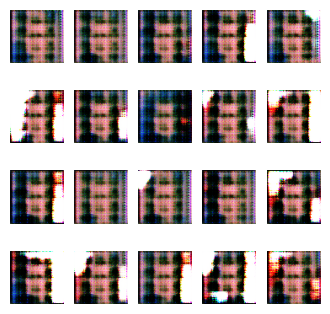

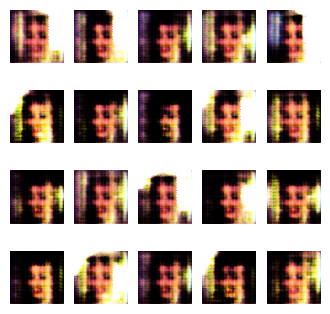

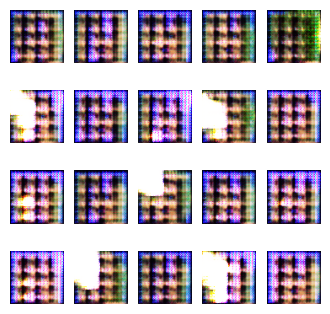

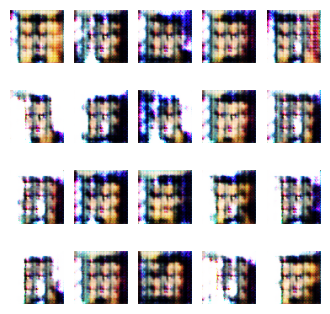

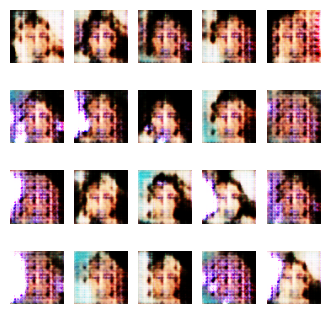

In [56]:
for make_images in img_list:
    # if make_images.shape[1] != 784:
    plt.figure(figsize=(4,4)) # 이미지 크기 지정
    for i in range(make_images.shape[0]): #이미지 갯수만큼 반복
        plt.subplot(4, 5, i+1) #바둑판식으로 표현
        plt.imshow(denorm(make_images[i]).permute(1, 2, 0))
        plt.axis('off')
    plt.show()

In [57]:
import matplotlib.pyplot as plt
def plot_generated_images(generator):
    # 100개의 노이즈 값을 생성합니다.
    noise = torch.rand((100, 64, 1, 1), device=device)
    with torch.no_grad():
        make_images = generator(noise).detach().cpu() # 노이즈값을 통해서 GAN으로 이미지 생성합니다.
    make_images = make_images.reshape(100, 3, 64, 64) # Mnist 사이즈와 동일하게 바꿔줍니다.
    plt.figure(figsize=(10,10)) # 이미지 크기 지정
    for i in range(make_images.shape[0]): #이미지 갯수 100만큼 반복
        plt.subplot(10, 10, i+1) #바둑판식으로 표현
        plt.imshow(denorm(make_images[i]).permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()

In [58]:
plot_generated_images(model_g)

Output hidden; open in https://colab.research.google.com to view.